In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# 透過二元分類訓練 IMDB 評論資料

二元分類或稱兩類分類可能是在機器學習中應用最廣泛問題。只要處理的問題只有兩個結果，就可以適用。在這個例子中，我們將根據 IMDB 評論的文本內容將電影評論分為「正面」評論和「負面」評論。

## 關於 IMDB Dataset 資料集

IMDB Dataset 是來自 Internet 電影數據庫 50,000 條評論文字。他們分為 25,000 條訓練數據和 25,000 條測試數據，每組皆包含包括 50％ 的負面評論和 50％ 的正面評論。

我們可以直接透過 Keras Datasets 函式庫載入已經整理好的資料集。這些資料集已經經過處理，會將評論依據單詞順序，排列為整數序列，其中每個整數代表字典中的特定單詞。如下：

In [2]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


num_words=10000 表示我們只採用前 10000 個常出現的字詞，此外在 label 中 0 表示負評 1 表示正評。

In [3]:
max([max(sequence) for sequence in train_data])

9999

也可以透過字典檔，將資料組合回評論文字。

In [4]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
# show
decoded_review

1646592/1641221 [==============================] - 0s 0us/step


"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## 處理資料

我們無法將代表字典檔索引位置的整數資料直接送進網路進行訓練，因此需要對資料進行轉換。由於我們只採用前 10000 常用字詞作為資料集，因此輸入資料可以轉換為 10000 維度的 one-hot-encode，例如 [3, 18] 表示一個全部都是 0 的陣列，只有 index 3, 18 是 1。我們會將這樣的資料格式作為張量進行訓練，轉換如下：

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

將結果標記進行正規化

In [0]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 建立網路架構

這裡我們預計使用三層網路，全連接層僅使用兩層 16 個神經元的網路，啟動函數設定為 relu，連接最後使用一個神經元輸出（表示正評或負評），並使用 sigmoid 作為最後輸出的啟動函數。由下而上網路架構如下：

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


將優化器設定為 rmsprop，損失函數使用 binary_crossentropy，將網路進行 Compile

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 訓練模型

先將準備訓練的 25000 筆資料集，抽出 10000 筆資料集用在訓練時期的驗證資料，好讓我們監控訓練過程的準確性變化。如下：

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

開始訓練模型

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/100
15000/15000 [==============================] - 3s 191us/step - loss: 0.5370 - accuracy: 0.7950 - val_loss: 0.4182 - val_accuracy: 0.8629
Epoch 2/100
15000/15000 [==============================] - 1s 72us/step - loss: 0.3364 - accuracy: 0.8965 - val_loss: 0.3188 - val_accuracy: 0.8860
Epoch 3/100
15000/15000 [==============================] - 1s 75us/step - loss: 0.2441 - accuracy: 0.9236 - val_loss: 0.2855 - val_accuracy: 0.8909
Epoch 4/100
15000/15000 [==============================] - 1s 76us/step - loss: 0.1879 - accuracy: 0.9411 - val_loss: 0.2761 - val_accuracy: 0.8892
Epoch 5/100
15000/15000 [==============================] - 1s 75us/step - loss: 0.1532 - accuracy: 0.9527 - val_loss: 0.2893 - val_accuracy: 0.8842
Epoch 6/100
15000/15000 [==============================] - 1s 75us/step - loss: 0.1209 - accuracy: 0.9637 - val_loss: 0.2850 - val_accuracy: 0.8880
Epoch 7/100
15000/15000 [==============================] - 1s

訓練的過程會把相關資訊存放在 history，透過事後分析訓練過程的資訊可以幫助我們優化參數。

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

透過上面的方法可以取得訓練 History 包含的資訊，然後我們將資訊繪製成為圖表，如下：

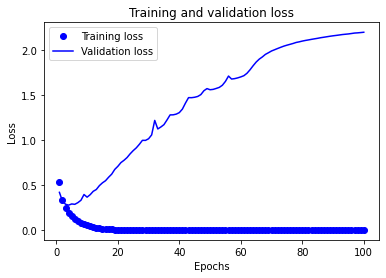

In [12]:
#@title
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

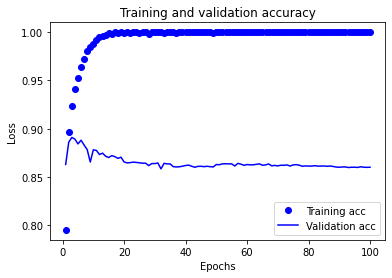

In [13]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

由上面的數據可以看出來，以現在的網路架構，其實在第 3 次 Epoch 就已經獲得最佳的結果，之後的訓練已經造成過度擬合 (Over Fitting)，因此在這個案例中將 Epoch 設定為 3 或 4 是取得最佳訓練模型的方法。